In [1]:
%run LanguageModel.py
%run DataLoader.py
%run rnn_utils.py
%run encoder.py
%run decoder.py
%run seq2seq.py
%run model_config.py
%run metrics.py
%run ScorePrinter.py

import numpy as np
import math
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dl = DataLoader('train', ('de', 'en'), max_length = 50, device = device)

In [4]:
val_dl = DataLoader('dev', ('de', 'en'), languageModels = train_dl.languageModels, max_length = 50, device = device)

In [5]:
lm1 = train_dl.languageModels[train_dl.languages[0]]
lm2 = train_dl.languageModels[train_dl.languages[1]]
model_config = ModelConfig(input_size = lm1.n_tokens, beam_width = 3, hidden_size = 256, output_size = lm2.n_tokens, rnn_type='lstm', bidirectional=True, attention = 'global_context', score = 'dot', max_length=52)
#checkpoint = torch.load("./state_dict.tar")
s2s = seq2seq(model_config=model_config, state_dict = None, device = device)

In [6]:
def train_epochs(epochs, print_every=1000):
    n_iters = len(train_dl)
    score_printer = ScorePrinter("Training", [('NLL', loss_metric),('Perplexity', perplexity), ('BLEU', bleu)])

    for epoch in range(1, epochs+1):
        score_printer.startEpoch(epoch)
        idx_permutation = np.random.permutation(len(train_dl))

        for i, index in enumerate(idx_permutation):
            input_tensor, target_tensor = train_dl.tensorsFromPos(index)

            loss, output_sentence = s2s.train(input_tensor, target_tensor)
            real_target_sentence, estimated_target_sentence = train_dl.real_estimated_sentence(target_tensor, output_sentence)
            score_printer.update(nll = loss, target_length = target_tensor.size(0), real_target_sentence=real_target_sentence, estimated_target_sentence=estimated_target_sentence)
            
            if (i + 1) % print_every == 0:
                score_printer.printAvg(print_every, last = 200)
        
        #score_printer.printAvg(len(train_dl))
        val_avg_score = validate(100)
        train_avg_score = score_printer.getAvgScores()
        with open('./Validation_scores' + str(epoch) + '.txt', 'a') as validation_scores, open('./Training_scores' + str(epoch) + '.txt', 'a') as training_scores:
            validation_scores.write(json.dumps(val_avg_score) + '\n')
            training_scores.write(json.dumps(train_avg_score) + '\n')
        #print(f"Val_avg_score: {val_avg_score}, train_avg_score: {train_avg_score}")
        score_printer.endEpoch(epoch)
        
        torch.save(s2s.state_dict(),"./state_dict_"+str(epoch)+".tar")

In [7]:
def validate(n = None):
    score_printer = ScorePrinter("Validation", [('NLL', loss_metric),('Perplexity', perplexity), ('BLEU', bleu)])
    n = n or len(val_dl)
    idx_permutation_val = np.random.permutation(len(val_dl))[:n]
    score_printer.beginMeasurements()
    for j, val_index in enumerate(idx_permutation_val):
        input_tensor_val, target_tensor_val = val_dl.tensorsFromPos(val_index)
        loss, output_sentence = s2s.evaluate(input_tensor_val, target_tensor_val)
        real_target_sentence, estimated_target_sentence = val_dl.real_estimated_sentence(target_tensor_val, output_sentence)
        print(f"real : {real_target_sentence}, est : {estimated_target_sentence}")
        score_printer.update(nll = loss, target_length = target_tensor_val.size(0), real_target_sentence  = real_target_sentence, estimated_target_sentence = estimated_target_sentence)
    score_printer.printAvg(showCount = False, last = 200)
    return score_printer.getAvgScores()

In [ ]:
train_epochs(5, print_every=1000)

In [9]:
from IPython.display import display, Markdown
def print_validation(position):
    print(val_dl.tensorsFromPos(position)[0])
    input_sentence = val_dl.sentenceFromTensor('de', val_dl.tensorsFromPos(position)[0])
    display(Markdown('**Eingabe**'))
    display(Markdown(' '.join(input_sentence)))
    prediction = s2s.predict(val_dl.tensorsFromPos(position)[0])
    output_sentence = val_dl.sentenceFromTensor('en', prediction[0])
    display(Markdown('**Ausgabe**'))
    display(Markdown(' '.join(output_sentence)))
    attentions = torch.stack([tensor.squeeze() for tensor in prediction[2]])
    attentions = attentions.numpy()[:len(output_sentence)-1,:len(input_sentence)]
    display(Markdown('**Attention**'))
    show_attention(input_sentence, output_sentence, attentions)

In [10]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def show_attention(input_sentence, output_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(16, 14), dpi= 80)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticks(np.arange(len(output_sentence[1:])))
    ax.set_yticklabels(output_sentence[1:]) # ignore SOS Token

    plt.show()

tensor([[  115],
        [  606],
        [ 2221],
        [  372],
        [  722],
        [11256],
        [  652],
        [   30],
        [   11],
        [ 3585],
        [  190],
        [11271],
        [    4],
        [   14],
        [  319],
        [    2],
        [    4],
        [  708],
        [   45],
        [   44],
        [ 1176],
        [   27],
        [  483],
        [   97],
        [10365],
        [53351],
        [  691],
        [   37],
        [   27],
        [   96],
        [ 2166],
        [  189],
        [  267],
        [   36],
        [    1]])
['es', 'gibt', 'außerdem', 'auch', 'einige', 'nette', 'möglichkeiten', 'in', 'der', 'bildung', 'wie', 'sprachen', ',', 'mathematik', 'oder', 'UNK', ',', 'wo', 'wir', 'den', 'leuten', 'die', 'möglichkeit', 'des', 'schnellen', 'ausprobierens', 'geben', 'und', 'die', 'ergebnisse', 'sofort', 'sehen', 'wollen', '.', 'EOS']


**Eingabe**

es gibt außerdem auch einige nette möglichkeiten in der bildung wie sprachen , mathematik oder UNK , wo wir den leuten die möglichkeit des schnellen ausprobierens geben und die ergebnisse sofort sehen wollen . EOS

**Ausgabe**

SOS and i have EOS

**Attention**

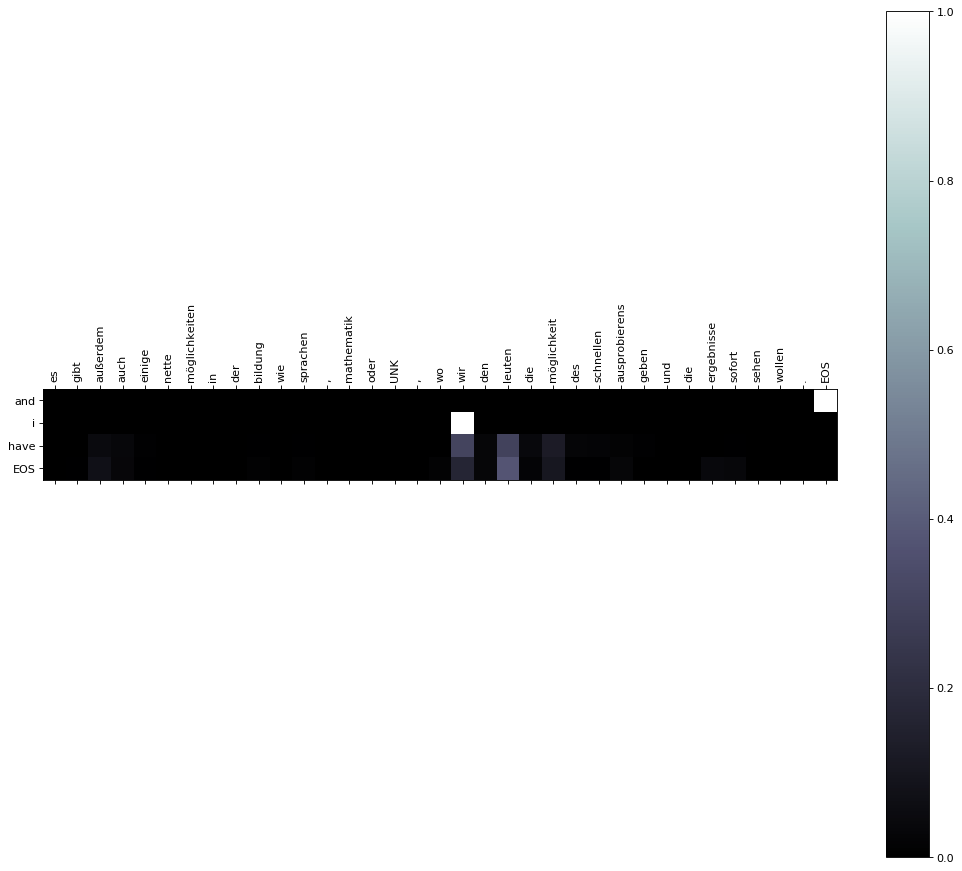

In [11]:
print_validation(19)